In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 3.5 MB/s eta 0:00:00


In [2]:
pip install pymc==5.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.1/469.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [3]:
pip show numba

Name: numba
Version: 0.56.4
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: llvmlite, numpy, setuptools
Required-by: librosa


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [5]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

Mounted at /drive


In [6]:
#combine
all_data = pd.concat((raw22, raw21, raw20))

del raw22
del raw21
del raw20

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles. It seems intuitive to remove angles greater than 45 degrees for the foul line.
#However, I only have balls in play in my dataset, and yet there are a lot of balls with angles greater than 45 degrees.
#I don't know if that is bad measurements or an effect of the wind or what, but if I cut off the angles too soon, when I go
#to fit the beta dists, I get really steep lines at 0 and 1, like undefined slopes almost, which messes up the advi optimizer,
#so it works better if I cut it off at 55 and then when I go to sample batted balls to optimize for positioning, I will remove batted
#balls from the sample that land at an angle greater than 45 because those are foul.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd']]

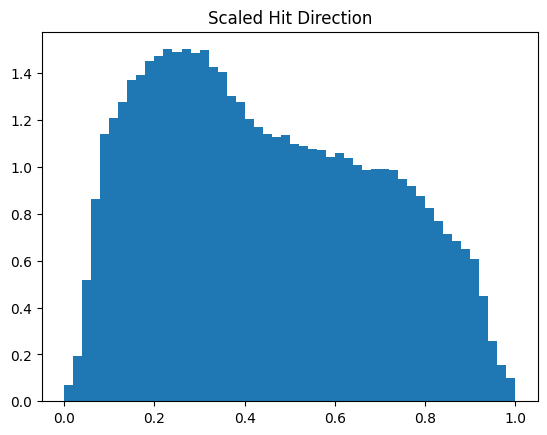

In [7]:
plt.hist(all_data.hd.values, density = True, bins = 50)
plt.title('Scaled Hit Direction')
plt.show()

In [8]:
#train test split
train,test = train_test_split(all_data, train_size = 0.7, random_state = 42)

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(train.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

train = train.merge(batter_indices, on = 'batter_id_hand')
test = test.merge(batter_indices, on = 'batter_id_hand', how = 'inner')

### **Model:** Mixture of Betas

In [9]:
#for the prior for the weights, I'm just going to go with dirichlet([0.4,0.6]), so just use the exact probabilities I found in the exploratory notebook.
#for the priors for the alpha and beta parameters in the beta distributions, I want them to have mean of [3,3] for alpha and [9,2] for beta based on
#what I found in the exploratory notebook, but I don't know what to do with variance. So I am just going to try to match the variance I had in the
#hit direction 1 notebook, which was about 0.024 and 0.027 for alpha and beta repsectively. I'll go a little bit bigger than that to be safe, 0.03 and 0.03
weight_prior_alpha = np.array([0.4, 0.6])
alpha_prior_mean = np.array([3,3])
alpha_prior_var = np.array([0.03,0.03])
beta_prior_mean = np.array([9,2])
beta_prior_var = np.array([0.03,0.03])

In [10]:
n_batters = len(train.batter_index.unique())
nclusters = 2
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'clusters': [1,2]}

with pm.Model(coords = coords) as mod1:

    ####hyperpriors
    #gamma dist for the prior for the alpha in the dirichlet distribution. Gamma will ensure that we don't get any nonpositive values
    weight_alpha_prior = pm.Gamma('weight_alpha_prior', mu = np.array([4,6]), sigma = np.array([10,10]))

    #gamma dist for the prior for the mean in the batter alphas and batter betas. This ensures positive means
    alpha_mu_prior = pm.Gamma('alpha_mu_prior', mu = np.array([3,3]), sigma = np.array([10,10]))
    beta_mu_prior = pm.Gamma('beta_mu_prior', mu = np.array([9,2]), sigma = np.array([10,10]))

    #half normals for the sigma priors
    alpha_sigma_prior = pm.HalfNormal('alpha_sigma_prior', sigma = np.ones(nclusters))
    beta_sigma_prior = pm.HalfNormal('beta_sigma_prior', sigma = np.ones(nclusters))

    #### batter specific beta dists
    #prior for the alpha parameter in the beta dists
    batteralphas = pm.Gamma('batteralphas', mu = alpha_mu_prior, sigma = alpha_sigma_prior, dims = ('batter', 'clusters'))

    #prior for the beta parameter in the beta dists
    batterbetas = pm.Gamma('batterbetas', mu = beta_mu_prior, sigma = beta_sigma_prior, dims = ('batter', 'clusters'))

    #the batter weights have a prior of dirichlet(alpha_prior)
    batterweights = pm.Dirichlet('batterweights', a = weight_alpha_prior, dims = ('batter', 'clusters'))

    b = pm.Data("b", train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.hd.values, dims = 'observation')

    #each observation is distributed as a mixture of betas with alpha given by batter_alphas, beta given by batterbetas, and weights given by the batter weights.
    bets = pm.Beta.dist(alpha = batteralphas[b], beta = batterbetas[b], shape = (train.shape[0],2))
    likelihood = pm.Mixture('likelihood', w= batterweights[b], comp_dists = bets, observed = x, dims = 'observation')

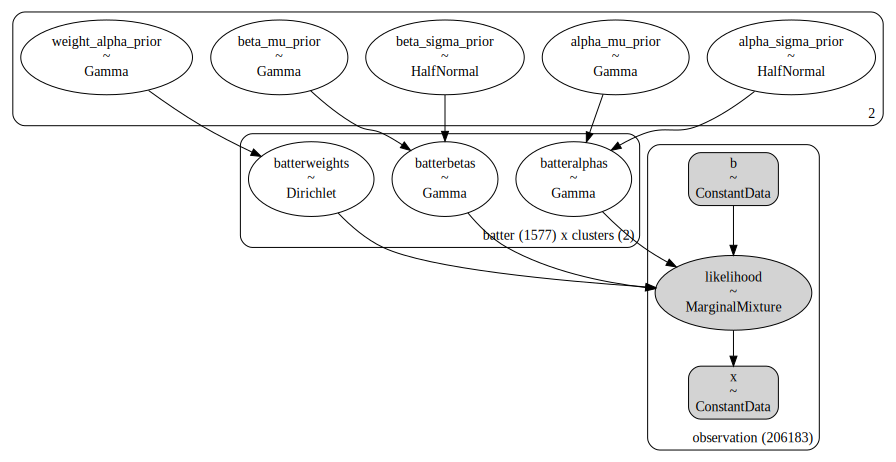

In [11]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    trace = pmjax.sample_numpyro_nuts(2000,2000,chains=1, random_seed=42)

Compiling...
Compilation time =  0:01:13.715330
Sampling...


sample: 100%|██████████| 4000/4000 [38:15<00:00,  1.74it/s, 11 steps of size 5.57e-02. acc. prob=0.79]


Sampling time =  0:38:30.784902
Transforming variables...
Transformation time =  0:00:00.518996


In [12]:
with mod1:
    inference = pm.ADVI()
    approx = pm.fit(n=20000, method = inference)

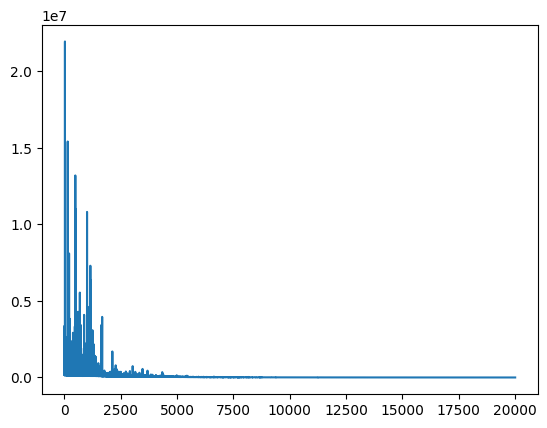

In [13]:
plt.plot(inference.hist, label = 'advi')
plt.show()
trace = approx.sample(2000)

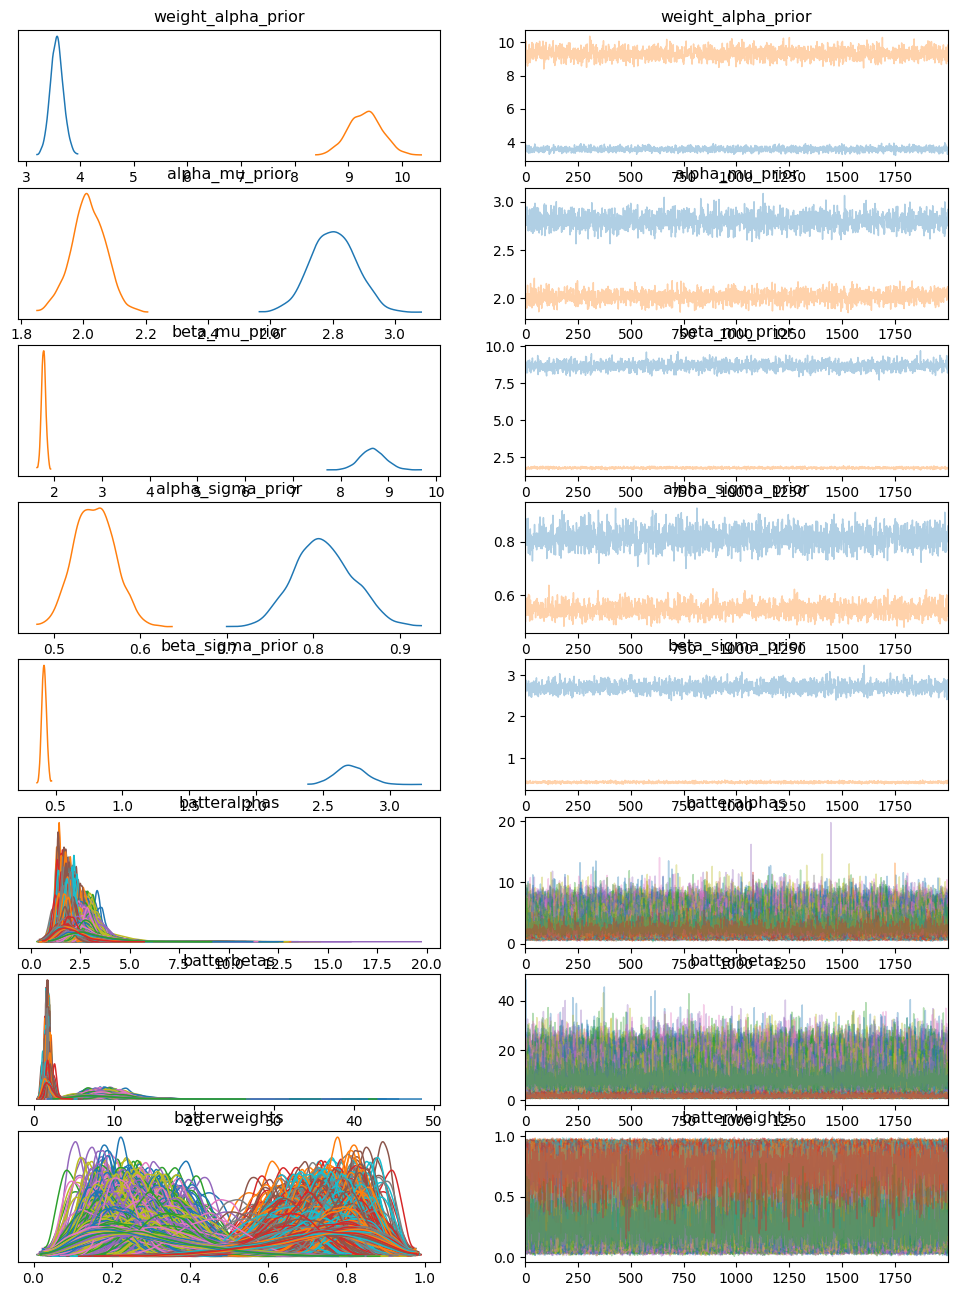

In [14]:
az.plot_trace(trace)
plt.show()

In [15]:
balphas = trace.posterior.batteralphas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_alpha1', 'batter_alpha2']] = balphas
bbs = trace.posterior.batterbetas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_beta1', 'batter_beta2']] = bbs
bweights = trace.posterior.batterweights.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_w1', 'batter_w2']] = bweights

train = train.merge(batter_indices[['batter_index', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], on = 'batter_index')
test = test.merge(batter_indices[['batter_index', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], on = 'batter_index')

In [16]:
train['log_like'] = np.log(train.batter_w1.values * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).pdf(train.hd.values) + train.batter_w2.values * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).pdf(train.hd.values))
test['log_like'] = np.log(test.batter_w1.values * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).pdf(test.hd.values) + test.batter_w2.values * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).pdf(test.hd.values))
train.log_like.mean(), test.log_like.mean()

(0.1093158627524339, 0.09701560572751337)

In [ ]:
train['log_like'] = np.log(train.batter_w1.values * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).pdf(train.hd.values) + train.batter_w2.values * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).pdf(train.hd.values))
test['log_like'] = np.log(test.batter_w1.values * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).pdf(test.hd.values) + test.batter_w2.values * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).pdf(test.hd.values))
train.log_like.mean(), test.log_like.mean()

(0.1043341214213768, 0.09956016280066025)

That's slightly better than what I had before with the single beta dist, and I think the test log likelihood is slightly better than when we didn't have the hyperprior

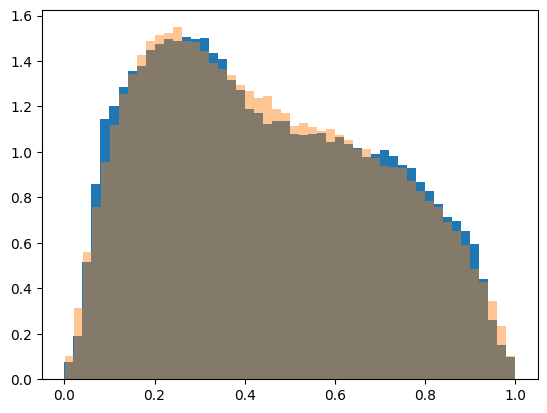

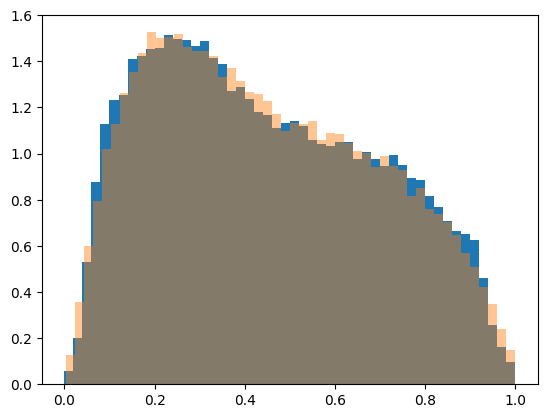

In [17]:
#draw a sample for each hd in train
choice = np.random.binomial(1, train.batter_w1.values, size = train.shape[0])
samp = choice * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).rvs() + (1-choice) * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).rvs()
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.45)
plt.show()

#test
choice = np.random.binomial(1, test.batter_w1.values, size = test.shape[0])
samp = choice * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).rvs() + (1-choice) * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).rvs()
plt.hist(test.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.45)
plt.show()

That looks a lot better than what we had before without the hyperpriors

### **QQ Plot**

In [ ]:
# I think you have to compute ppf numerically in a mixture model so I'm going to hold off on that

### **PP Plot**

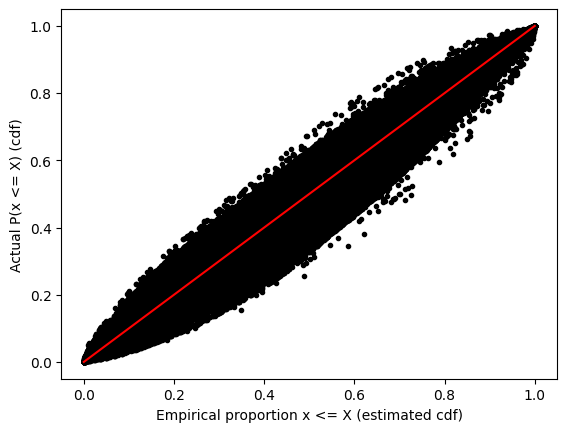

In [18]:
def pp_plot2(weights, alphas, betas, data):
    cdf_estimate = np.array([np.mean(i >= data) for i in data])
    cdf_actual = weights[0] * beta(a = alphas[0], b = betas[0]).cdf(data) + weights[1]* beta(a = alphas[1], b = betas[1]).cdf(data)
    plt.plot(cdf_estimate, cdf_actual, 'k.')
    plt.plot(np.sort(cdf_actual), np.sort(cdf_actual), 'r-')
    plt.xlabel('Empirical proportion x <= X (estimated cdf)')
    plt.ylabel('Actual P(x <= X) (cdf)')
    plt.show()

pp_plot2(np.vstack((train.batter_w1.values, train.batter_w2.values)), np.vstack((train.batter_alpha1.values, train.batter_alpha2.values)), np.vstack((train.batter_beta1.values, train.batter_beta2.values)), train.hd.values)

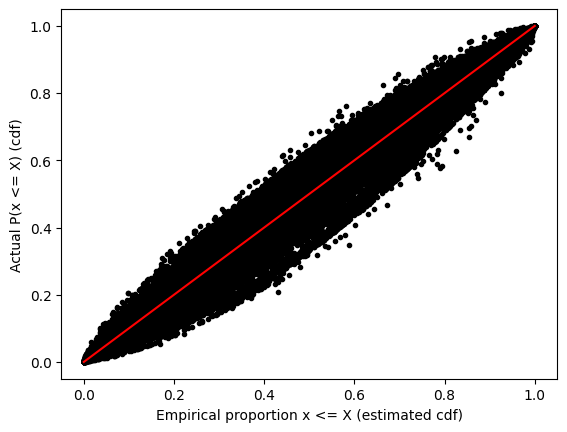

In [19]:
pp_plot2(np.vstack((test.batter_w1.values, test.batter_w2.values)), np.vstack((test.batter_alpha1.values, test.batter_alpha2.values)), np.vstack((test.batter_beta1.values, test.batter_beta2.values)), test.hd.values)

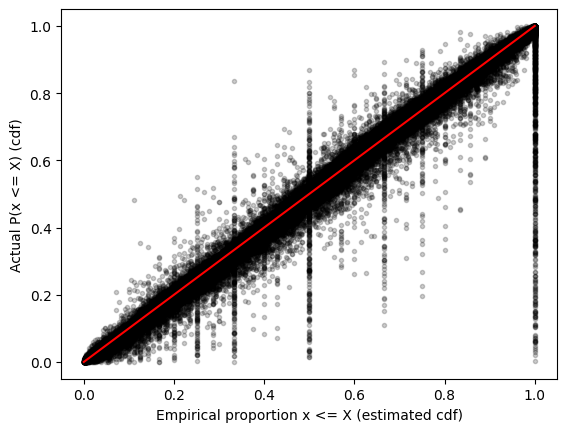

In [20]:
def pp_plot3(dataframe):
    for b in dataframe.batter_index.unique():
        data = dataframe.loc[dataframe.batter_index == b]
        cdf_estimate = np.array([np.mean(i >= data.hd.values) for i in data.hd.values])
        m1 = data.batter_alpha1.values[0]
        m2 = data.batter_alpha2.values[0]
        s1 = data.batter_beta1.values[0]
        s2 = data.batter_beta2.values[0]
        w1 = data.batter_w1.values[0]
        w2 = data.batter_w2.values[0]
        cdf_actual = w1 * beta(a=m1,b=s1).cdf(data.hd.values) + w2* beta(a=m2,b=s2).cdf(data.hd.values)
        plt.plot(cdf_estimate, cdf_actual, 'k.', alpha = 0.2)
    plt.plot([0,1],[0,1], 'r-')
    plt.xlabel('Empirical proportion x <= X (estimated cdf)')
    plt.ylabel('Actual P(x <= X) (cdf)')
    plt.show()

pp_plot3(train)

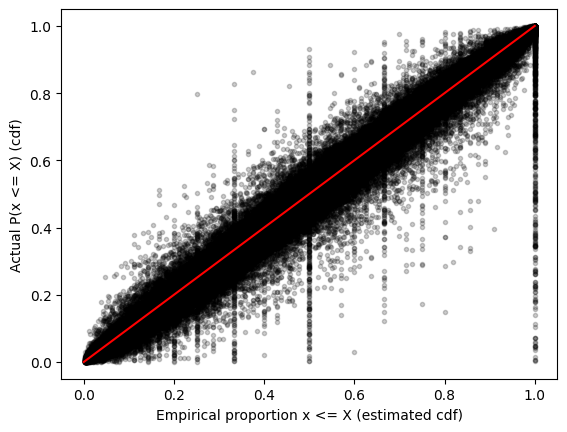

In [21]:
pp_plot3(test)

### **Individual Hitter**

In [22]:
all_data = pd.concat((train, test))
lowe = all_data.loc[all_data.batter == 663993]
gallo = all_data.loc[all_data.batter == 608336]
chas = all_data.loc[all_data.batter == 676801]
breg = all_data.loc[all_data.batter == 608324]
yandy = all_data.loc[all_data.batter == 650490]

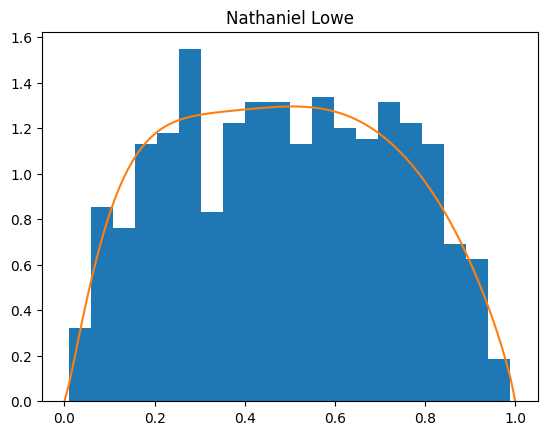

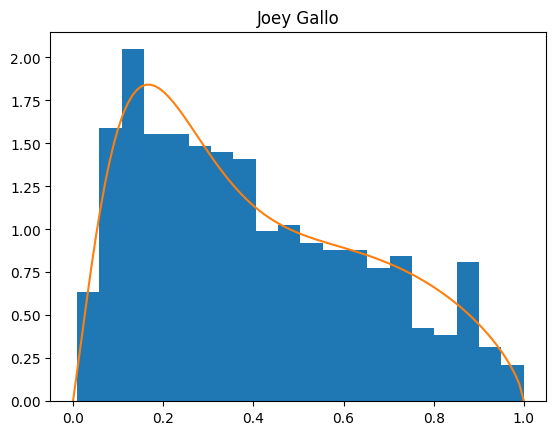

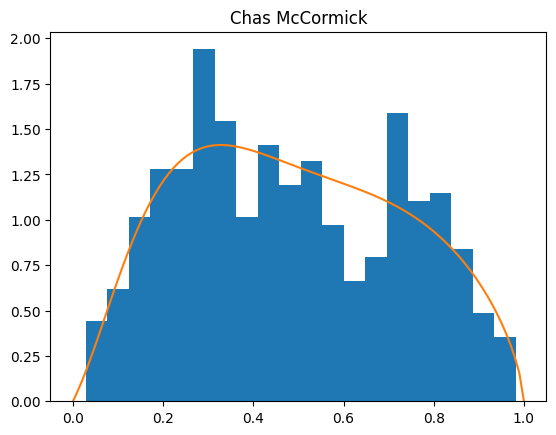

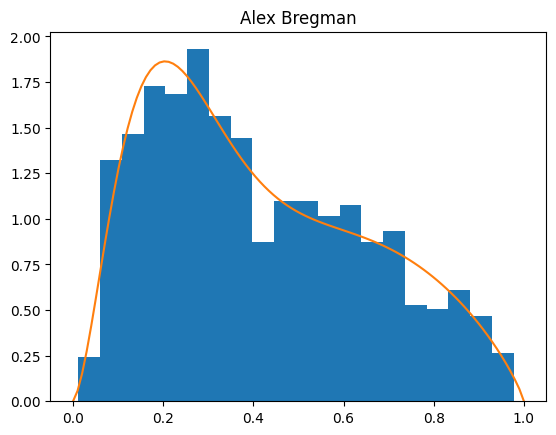

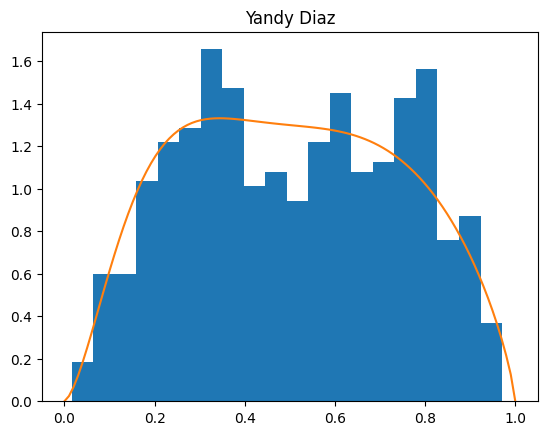

In [23]:
x = np.linspace(0,1,100)
plt.hist(lowe.hd.values, density = True, bins=20)
plt.plot(x, lowe.batter_w1.values[0] * beta(a = lowe.batter_alpha1.values[0], b = lowe.batter_beta1.values[0]).pdf(x) + lowe.batter_w2.values[0] * beta(a = lowe.batter_alpha2.values[0], b = lowe.batter_beta2.values[0]).pdf(x), '-')
plt.title('Nathaniel Lowe')
plt.show()

plt.hist(gallo.hd.values, density = True, bins=20)
plt.plot(x, gallo.batter_w1.values[0] * beta(a = gallo.batter_alpha1.values[0], b = gallo.batter_beta1.values[0]).pdf(x) + gallo.batter_w2.values[0] * beta(a = gallo.batter_alpha2.values[0], b = gallo.batter_beta2.values[0]).pdf(x), '-')
plt.title('Joey Gallo')
plt.show()

plt.hist(chas.hd.values, density = True, bins=20)
plt.plot(x, chas.batter_w1.values[0] * beta(a = chas.batter_alpha1.values[0], b = chas.batter_beta1.values[0]).pdf(x) + chas.batter_w2.values[0] * beta(a = chas.batter_alpha2.values[0], b = chas.batter_beta2.values[0]).pdf(x), '-')
plt.title('Chas McCormick')
plt.show()

plt.hist(breg.hd.values, density = True, bins = 20)
plt.plot(x, breg.batter_w1.values[0] * beta(a = breg.batter_alpha1.values[0], b = breg.batter_beta1.values[0]).pdf(x) +breg.batter_w2.values[0] * beta(a = breg.batter_alpha2.values[0], b = breg.batter_beta2.values[0]).pdf(x), '-')
plt.title('Alex Bregman')
plt.show()

plt.hist(yandy.hd.values, density = True, bins=20)
plt.plot(x, yandy.batter_w1.values[0] * beta(a = yandy.batter_alpha1.values[0], b = yandy.batter_beta1.values[0]).pdf(x) + yandy.batter_w2.values[0] * beta(a = yandy.batter_alpha2.values[0], b = yandy.batter_beta2.values[0]).pdf(x), '-')
plt.title('Yandy Diaz')
plt.show()

Not a significant difference, but the hyperpriors seemed to improve things just slightly. May not be worth the trouble. Let's look at the posterior estiamtes of the hyperpriors.

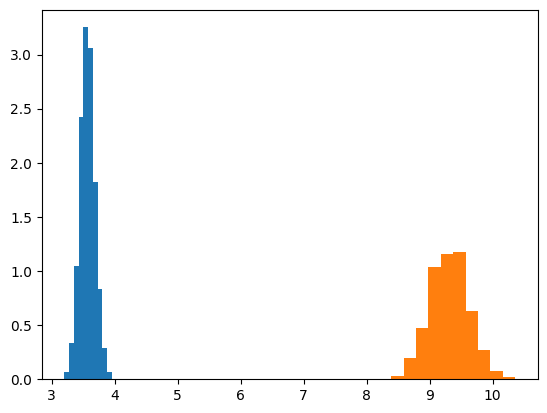

In [25]:
weight_alpha_post = trace.posterior.weight_alpha_prior.to_numpy()[0]
plt.hist(weight_alpha_post[:,0], density = True)
plt.hist(weight_alpha_post[:,1], density = True)
plt.show()

These are very different from the priors, which had means of 4 and 6.

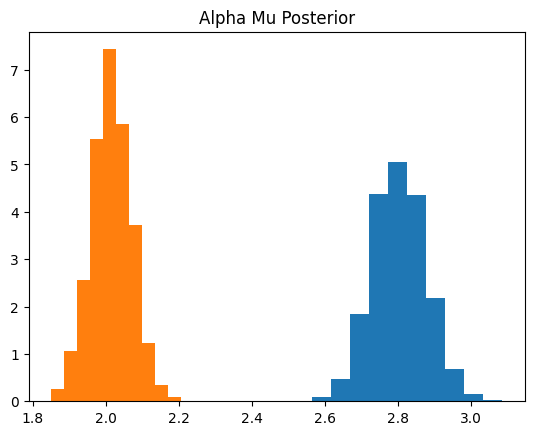

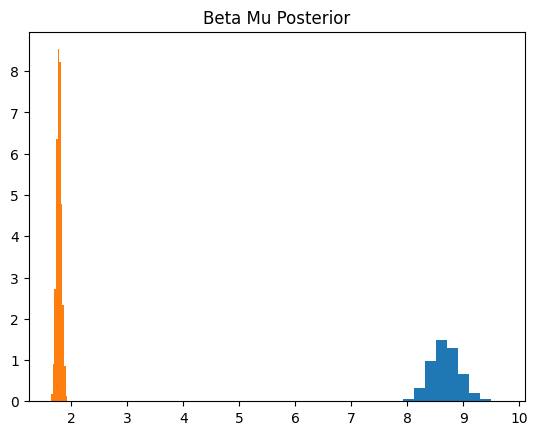

In [26]:
alpha_mu_post = trace.posterior.alpha_mu_prior.to_numpy()[0]
plt.hist(alpha_mu_post[:,0], density = True)
plt.hist(alpha_mu_post[:,1], density = True)
plt.title('Alpha Mu Posterior')
plt.show()

beta_mu_post = trace.posterior.beta_mu_prior.to_numpy()[0]
plt.hist(beta_mu_post[:,0], density = True)
plt.hist(beta_mu_post[:,1], density = True)
plt.title('Beta Mu Posterior')
plt.show()

These are different from the priors of 3 and 3 and 2 and 9

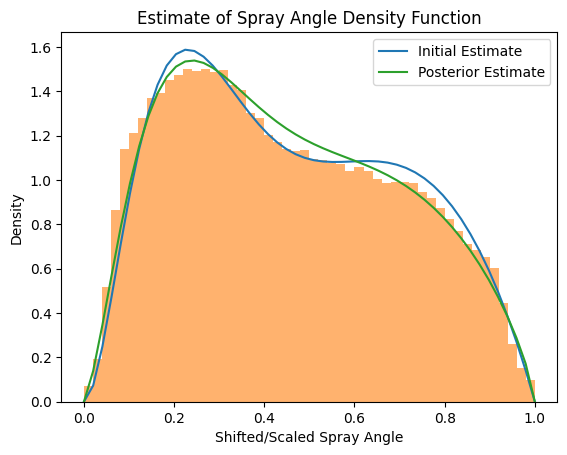

In [29]:
x = np.linspace(0,1)
plt.plot(x, .4*beta(a = 3, b=9).pdf(x)+ 0.6*beta(a=3,b=2).pdf(x), '-', label = 'Initial Estimate')
post_weights = weight_alpha_post.mean(axis = 0)/weight_alpha_post.sum(axis = 1).mean()
post_alpha = alpha_mu_post.mean(axis = 0)
post_beta = beta_mu_post.mean(axis=0)
plt.hist(all_data.hd.values, density = True, bins = 50,alpha = 0.6)
plt.plot(x, post_weights[0]*beta(post_alpha[0], post_beta[0]).pdf(x) + post_weights[1]*beta(post_alpha[1], post_beta[1]).pdf(x), '-', label = 'Posterior Estimate')
plt.legend()
plt.xlabel('Shifted/Scaled Spray Angle')
plt.ylabel('Density')
plt.title('Estimate of Spray Angle Density Function')
plt.show()

In [ ]:
post_weights[0], post_weights[1]

(0.27525849901943966, 0.72474150098056)

In [ ]:
post_alpha[0]/(post_alpha[0] + post_beta[0]), post_alpha[1]/(post_alpha[1] + post_beta[1])

(0.24402005085883588, 0.5317357023058947)

I get slightly different and arguably slightly more overfit (worse log like on test set but better on train set) when I use ADVI. However, the MCMC trace plots are not looking good, so I may have to use ADVI anyways if I can't get that figured out.